In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
#realisation of AR(p)
def ar_p(n, theta, sigma):
    x = np.random.normal(0,sigma,len(theta))
    for i in range(n):
        x = np.append(x,(np.sum(theta*x[-1:-(len(theta)+1):-1])+np.random.normal(0,sigma,1)))
    return x

In [55]:
# LSE for AR(p)
def LSE(x,theta,n1,p):
    #p=len(theta)
    num=0
    den=0
    for i in range(p+1,n1):
        var = np.reshape(x[i-1:i-p-1:-1],(p,1))
        num += var * x[i]
        den += var @ var.transpose()
    den = np.linalg.inv(den)
    return ((den @ num).reshape(1,p)[0])

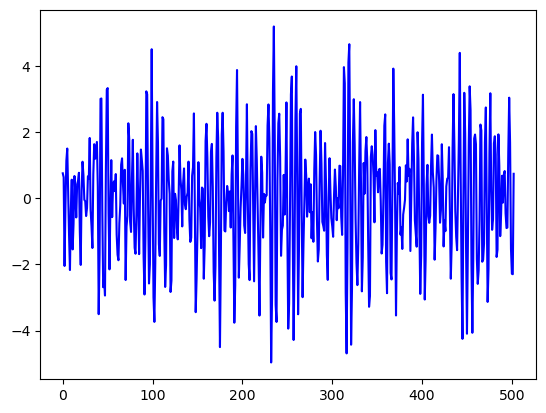

In [56]:
# example of AR(3)
n = 500
theta = np.array([ 0.51168823, -0.6182312 , -0.232489  ])

sigma=1
ar=ar_p(n,theta,sigma)
plt.plot(ar, color = 'b')

In [57]:
# binary search
def semi_int_nu(f_1, a, b, delta):
    left = a
    right = b
    f_a = f_1(left)
    f_b = f_1(right)
    c = (left + right) / 2
    f_c = f_1(c)
    if ((abs(left - right) > delta) | (abs(f_1(left)-f_1(right)) > delta)):
        if (f_c < 0):
            return semi_int_nu(f_1, left, c, delta)
        else:
             return semi_int_nu(f_1, c, right, delta)
    else:
        return((left+right)/2)

In [58]:
# Sequential estimator for AR(p) parameter

def est_var(theta, sigma, n1, n2, h, delta):
    # check condition
    if n1>=n2:
        print(f'{n1} >= {n2}')
        return 0
    p = len(theta)
    x = np.random.normal(0, sigma, p)

    # accumulation of the sample to pilot estimator
    for i in range(n1):
        x = np.append(x, (np.sum(theta * x[-1 : -(len(theta) + 1) : -1]) + np.random.normal(0, sigma, 1)))
    
    #Stage of estimation of the noise variance 
    theta_est = LSE(x,theta,n1,p)
    Sn1n2 = 0
    for i in range(n1,n2):
        x = np.append(x, (np.sum(theta * x[-1 : -(len(theta) + 1) : -1]) + np.random.normal(0, sigma, 1)))
        Sn1n2 += (x[-1] - np.sum(theta_est * x[-2 : -(p + 2) : -1])) ** 2
    Gamma = 1 / (n2 - n1 - 2) * Sn1n2 
    
    # Sequential estimation
    A = np.zeros((p, p))
    B = np.zeros((p, 1))
    lin_ind = [x[-2 : -(p + 2) : -1]]
    
    #check linear independent
    while abs(np.linalg.det(A)) < 10 ** (-5):
        x = np.append(x,(np.sum(theta * x[-1 : -(p + 1) : -1]) + np.random.normal(0, sigma, 1)))
        lin_ind.append(x[-2 : -(p + 2) : -1])
        k = 0
        for i in range(len(lin_ind) - 1):
            two_vec = np.array([lin_ind[i], lin_ind[-1]])
            if np.linalg.matrix_rank(two_vec) == 2:
                k += 1
        if k == (len(lin_ind)-1):
            nu = (Gamma * np.sum(x[-2:-(p+2):-1] ** 2)) ** (-1/2)
        else:
            nu = 0
        A += nu * x[-2 : -(p + 2) : -1].reshape(p, 1) @ x[-2 : -(p + 2) : -1].reshape(1, p)
        B += nu * x[-2 : -(p + 2) : -1].reshape(p, 1) * x[-1]
        
    # calculating sequential part of estimator
    min_lam = 0
    sum_nu2X2 = 0
    A1 = np.zeros((p, p))
    B1 = np.zeros((p, 1))
    A_add = np.zeros((p, p))
    while min_lam < h:
        x = np.append(x, (np.sum(theta * x[-1 : -(p + 1) : -1]) + np.random.normal(0, sigma, 1)))
        x_p = x[-2 : -(p + 2) : -1]
        A_add = x_p.reshape(p, 1) @ x_p.reshape(1, p)
        norm2_x_p = x_p.reshape(1, p) @ x_p.reshape(p, 1)
        eq = lambda z: float(np.min(np.linalg.eigvals(A + z * A_add)) / Gamma - float(sum_nu2X2 + z ** 2 * norm2_x_p))
        nu = float(semi_int_nu(eq, 0, 1 / Gamma, delta))
        A += nu * A_add
        B += nu * x_p.reshape(p, 1) * x[-1]
        sum_nu2X2 += nu ** 2 * norm2_x_p
        min_lam = float(np.min(np.linalg.eigvals(A)))

    #decreasing last coefficient nu_tau
    A1 = A - nu * A_add
    B1 = B - nu * x_p.reshape(p, 1) * x[-1]
    sum_nu2X21 = sum_nu2X2 - nu ** 2 * norm2_x_p
    nu_tau_f = lambda z: (float(np.min(np.linalg.eigvals(A1 + z * A_add))) - h)
    nu_tau = float(semi_int_nu(nu_tau_f, 0, nu, delta))
    zz = float(np.min(np.linalg.eigvals(A1 + nu_tau * A_add)) / Gamma - float(sum_nu2X21 + nu_tau**2 * norm2_x_p))
    A1 += nu_tau * A_add
    B1 += nu_tau * x_p.reshape(p,1) * x[-1]
    rez = np.linalg.inv(A1) @ B1
    rez = np.append(rez, len(x))
    return(rez)

In [63]:
# Monte-Carlo
theta = np.array([ 0.51168823, -0.6182312 , -0.232489  ])
p = len(theta)
n1n2=[[10, 30],[20,30]]
h = [10, 50]
sigma = [2, 5]
delta = 0.0001
N = 100

rez_tab = []
for j in sigma:
    for i in range(len(n1n2)):
        rez = np.array([])
        for k in range(N):
            rez = np.append(rez, est_var(theta, j, n1n2[i][0], n1n2[i][1], h[i], delta))

        rez1 = rez.reshape((N,(p+1)))
        rez2 = np.array([])
        tau = np.array([])
        
        for ii in range(N):
            rez2 = np.append(rez2, rez1[ii][:p])
            tau = np.append(tau, rez1[ii][p])
            
        rez3 = rez2.reshape((N,p))
        S = 0
        for iii in range(N):
            S += np.linalg.norm(rez3[iii] - theta) ** 2
        rez_tab.append([j, n1n2[i][0], n1n2[i][1], h[i], S / N, np.mean(tau), (h[i] + p -1) / h[i] ** 2])
data = pd.DataFrame(rez_tab,columns=['b', 'n1', 'n2', 'h', 'Delta', 'tau', 'bound'])


C:\Users\andre\AppData\Local\Temp\ipykernel_10508\3878994630.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eq = lambda z: float(np.min(np.linalg.eigvals(A + z * A_add)) / Gamma - float(sum_nu2X2 + z ** 2 * norm2_x_p))
C:\Users\andre\AppData\Local\Temp\ipykernel_10508\3878994630.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz = float(np.min(np.linalg.eigvals(A1 + nu_tau * A_add)) / Gamma - float(sum_nu2X21 + nu_tau**2 * norm2_x_p))


In [64]:
data

,b,n1,n2,h,Delta,tau,bound
0,2,10,30,10,0.033721,315.47,0.1200
1,2,20,30,50,0.011031,897.77,0.0208
2,5,10,30,10,0.041154,331.66,0.1200
3,5,20,30,50,0.009822,911.02,0.0208


In the result we can see that values in the column under the title "Delta" less than corresponding values in the column "bound". This fact agrees with the theoretical result.